# Previsão de Engajamento - Classificação

Este notebook define modelos e hiperparâmetros e executa um validação cruzada aninhada com grid search para otimização de hiperparâmetros e treinamento.

- Entrada: `full-preproc2-inputs` e `full-preproc2-outputs`
- Saída: `resultados/resultados50p_{START_DATE_STR}_{SUB_DATASET}.npy`


In [98]:
#@title Importações de pacote
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
BASE_PATH = 'dados/preprocessed/'
MODEL_NAME = 'paraphrase-multilingual-MiniLM'
SOCIAL_NETWORK = 'tiktok'

# 1 - Carregando os Dados

Carregando dados brutos gerais.

In [100]:
dfx = pd.read_excel(BASE_PATH + 'full-preproc2-inputs_'+ MODEL_NAME + SOCIAL_NETWORK+'.xlsx', index_col='ID')
dfx.drop(columns=["Only Hashtags"],inplace=True)
dfx.head()

,Candidato_Bolsonaro,Candidato_Lula,Dias Decorridos,x1,x2,x3,x4,x5,x6,x7,...,x375,x376,x377,x378,x379,x380,x381,x382,x383,x384
ID,,,,,,,,,,,,,,,,,,,,,
7115033431473474822,0,1,94,-0.222600,0.258170,0.165599,-0.210579,0.359918,-0.001123,0.007566,...,0.370087,-0.112563,-0.277257,0.095219,-0.293415,0.101862,0.038032,0.054848,0.059788,0.128184
7115174031162215686,0,1,94,-0.076441,-0.064013,0.016690,-0.081831,0.298343,0.040669,0.071783,...,0.350493,-0.280780,-0.125492,-0.041718,-0.195529,-0.040299,0.187845,-0.148987,-0.014888,0.192366
7115357413712153861,0,1,93,0.003736,0.173703,0.069491,-0.038313,-0.085404,-0.034746,0.297337,...,0.187329,-0.236962,-0.093682,0.024438,-0.181835,0.066457,0.473372,0.165317,-0.125917,0.037030
7115560675824422149,0,1,93,0.132854,0.273314,0.032846,0.054065,0.072919,-0.185590,-0.107564,...,0.437255,-0.047085,-0.061093,-0.154030,0.163679,0.031437,0.250211,-0.098645,-0.540223,0.066467
7115793869152734470,0,1,92,0.194997,0.037579,0.097597,0.009470,0.182514,0.009474,0.106134,...,0.350993,0.008871,-0.096121,0.198289,0.080491,-0.023066,0.469067,0.263451,-0.396818,0.258626


In [101]:
dfy_full = pd.read_excel(BASE_PATH + 'full-preproc2-outputs_'+ MODEL_NAME + SOCIAL_NETWORK +'.xlsx', index_col='ID')
dfy_full.head()

,Curtidas,Curtidas-Log,Curtidas-MinMax,Curtidas-Log-MinMax,Curtidas-2Classes-50p
ID,,,,,
7115033431473474822,11700,4.068186,0.005881,0.278511,0
7115174031162215686,33600,4.526339,0.018777,0.431384,1
7115357413712153861,34600,4.539076,0.019365,0.435634,1
7115560675824422149,47500,4.676694,0.026961,0.481554,1
7115793869152734470,22400,4.350248,0.012182,0.372628,1


## 1.1 - Escolha do Dataset (ALTERE)

In [102]:
from util import filter_dataset

# 'geral', 'lula' ou 'bolsonaro'
SUB_DATASET = 'lula'

TARGET_COL = 'Curtidas-2Classes-50p'

In [103]:
dfx, dfy = filter_dataset(dfx, dfy_full, SUB_DATASET, TARGET_COL)

Dataset LULA (indicador 1)


In [104]:
dfx.columns
dfx.shape

(308, 385)

In [105]:

dfy.head()
#dfy.shape

ID
7115033431473474822    0
7115174031162215686    1
7115357413712153861    1
7115560675824422149    1
7115793869152734470    1
Name: Curtidas-2Classes-50p, dtype: int64

## 1.2 - Informações do Treinamento (ALTERE)

In [106]:
from datetime import datetime

RANDOM_STATE = 1231

START_DATE_STR = datetime.now().strftime("%Y-%m-%d-%Hh%Mm")
#print(start_date_str)

metadata = dict()
metadata['date'] = START_DATE_STR
metadata['subdataset'] = SUB_DATASET
metadata['target'] = TARGET_COL
metadata['random_state'] = RANDOM_STATE

metadata['description'] =  f'''Treinamento com modelos com os 
dados balanceados (50p), com o dataset {SUB_DATASET}, com todos os modelos 
e com todos os ENSEMBLE, com a correção de escala para a MLP,
variando class_weight para os modelos que suportam'''

# 2 - Modelos

In [107]:
from sklearn.pipeline import Pipeline
from data_transformations_util import IdentityTransformer

In [108]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [109]:
lista_modelos = [
    {
        "nome_do_modelo": 'MLP Neural Network',
        "estimador": Pipeline([
            ('pca', PCA()),
            ('scaler', StandardScaler()), 
            ('predictor', MLPClassifier(random_state=42))
        ]),
        "parametros": {
            'pca': [PCA(n_components=10), PCA(n_components=20), PCA(n_components=30)],
            'scaler': [IdentityTransformer(), StandardScaler(), MinMaxScaler()],
            'predictor__hidden_layer_sizes': [(256,), (512,), (1024,)],  # Number of neurons in the hidden layer
            'predictor__learning_rate_init': [0.001, 0.01, 0.05],        # Learning rate
        }
    },
    {
        "nome_do_modelo": 'Support Vector Machine',
        "estimador": Pipeline([
            ('pca', PCA()),
            ('scaler', StandardScaler()), 
            ('predictor', SVC(random_state=42))   #SVC(probability=True) # muito lento?  Tempo médio de treinamento sem proba: 21.55 segundos / com proba: 35.11 segundos
        ]),
        "parametros": {
            'pca': [PCA(n_components=10), PCA(n_components=20), PCA(n_components=30)],
            'scaler': [IdentityTransformer(), StandardScaler(), MinMaxScaler()],
            'predictor__class_weight': ['balanced', None], 
            'predictor__C': [0.1, 1.0, 10.0, 20.0, 50.0],
            'predictor__gamma': ['scale', 'auto'],
            'predictor__kernel': ['rbf', 'sigmoid']  # removi 'linear' porque deixava lento!
        }
    },
    {
        "nome_do_modelo": 'Random Forest',
        "estimador": Pipeline([
            ('pca', PCA()),
            ('predictor', RandomForestClassifier(random_state=42))
        ]),
        "parametros": {
            'pca': [PCA(n_components=10), PCA(n_components=20), PCA(n_components=30)],
            'predictor__n_estimators': [10, 30, 70], 
            'predictor__class_weight': ['balanced', None], 
            'predictor__max_depth': [3, 4, 5, None],
            'predictor__min_samples_split': [2, 4, 8]
        }
    },
    {
        "nome_do_modelo": 'Logistic Regression',
        "estimador": Pipeline([
            ('pca', PCA()),
            ('scaler', StandardScaler()), 
            ('predictor', LogisticRegression(solver='saga', random_state=42))   # Saga is the only solver to support the 3 options for 'penalty'
        ]),
        "parametros": {
            'pca': [PCA(n_components=10), PCA(n_components=20), PCA(n_components=30)],
            'scaler': [IdentityTransformer(), StandardScaler(), MinMaxScaler()],
            'predictor__class_weight': ['balanced', None], 
            'predictor__C': [0.01, 0.1, 1.0, 2.0],         # Regularization parameter
            'predictor__penalty': ['l1', 'l2', None]       # Penalty term
        }
    },
    {
        "nome_do_modelo": 'KNN',
        "estimador": Pipeline([
            ('pca', PCA),
            ('scaler', StandardScaler()), 
            ('predictor', KNeighborsClassifier())
        ]),
        "parametros": {
            'pca': [PCA(n_components=10), PCA(n_components=20), PCA(n_components=30)],
            'scaler': [IdentityTransformer(), StandardScaler(), MinMaxScaler()],
            'predictor__n_neighbors': [5, 10, 15, 20], 
            'predictor__weights': ['uniform', 'distance'], 
            'predictor__p': [1, 2]
        }
    },

]

In [110]:
BASIC_MODEL_NAMES = [ mdl["nome_do_modelo"] for mdl in lista_modelos ]
metadata['basic_models'] = BASIC_MODEL_NAMES

BASIC_MODEL_NAMES

['MLP Neural Network',
 'Support Vector Machine',
 'Random Forest',
 'Logistic Regression',
 'KNN']

# 3 - Treinamento

In [111]:
from classification_train_util import nested_cross_validation_grid_search

A linha abaixo executa nested cross-validation, com um grid search nos *inner folds*, para cada modelo.




 **** RESULTADO DOS MODELOS + CURVAS ROC E PR ****

Treinando modelo MLP Neural Network .....
-- coletando e armazenando resultados --

 - Acurácia   : 0.5133 +/- 0.06579
 - Precisão   : 0.5107 +/- 0.05465
 - Revocação  : 0.5594 +/- 0.11765
 - F1 - Score : 0.5300 +/- 0.08144
 - ROC - AUC  : 0.5420 +/- 0.06090
 - PR - AUC   : 0.5675 +/- 0.05357
 - Tempo médio de treinamento: 32.50 segundos


Treinando modelo Support Vector Machine .....
-- coletando e armazenando resultados --

 - Acurácia   : 0.5162 +/- 0.05179
 - Precisão   : 0.5157 +/- 0.04533
 - Revocação  : 0.7097 +/- 0.14992
 - F1 - Score : 0.5904 +/- 0.05222
 - ROC - AUC  : 0.4081 +/- 0.06983
 - PR - AUC   : 0.4757 +/- 0.06029
 - Tempo médio de treinamento: 13.58 segundos


Treinando modelo Random Forest .....
-- coletando e armazenando resultados --

 - Acurácia   : 0.5359 +/- 0.05427
 - Precisão   : 0.5391 +/- 0.05287
 - Revocação  : 0.5525 +/- 0.06588
 - F1 - Score : 0.5428 +/- 0.04645
 - ROC - AUC  : 0.5468 +/- 0.05396
 - 

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


..

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


.
-- coletando e armazenando resultados --

 - Acurácia   : 0.5356 +/- 0.05961
 - Precisão   : 0.4347 +/- 0.22464
 - Revocação  : 0.4903 +/- 0.24685
 - F1 - Score : 0.4601 +/- 0.23386
 - ROC - AUC  : 0.5334 +/- 0.05451
 - PR - AUC   : 0.5507 +/- 0.05604
 - Tempo médio de treinamento: 7.81 segundos


Treinando modelo KNN .....
-- coletando e armazenando resultados --

 - Acurácia   : 0.5714 +/- 0.07347
 - Precisão   : 0.5579 +/- 0.06067
 - Revocação  : 0.7671 +/- 0.07897
 - F1 - Score : 0.6424 +/- 0.04774
 - ROC - AUC  : 0.5809 +/- 0.08920
 - PR - AUC   : 0.5900 +/- 0.08189
 - Tempo médio de treinamento: 5.41 segundos


Terminado em 14/03/2025 15:04:12


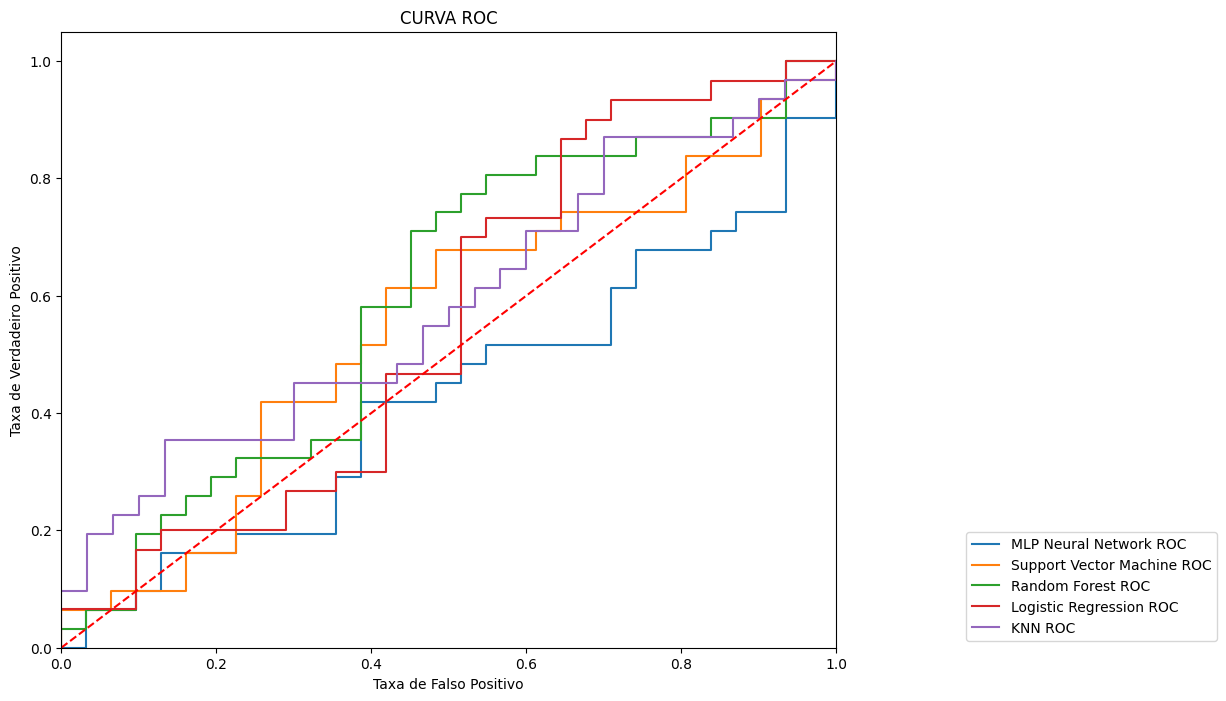

In [112]:

last_run_basic = nested_cross_validation_grid_search(lista_modelos, dfx, dfy, 5, 5, rand_state=RANDOM_STATE)


## 3.3 - Treina Ensembles (não foi publicado)

In [113]:
from copy import deepcopy

from ensemble_train_util import select_best_models_of_type_fn, select_best_models_per_fold
from ensemble_train_util import train_ensemble

In [114]:
last_run_all = deepcopy(last_run_basic)

In [115]:
#models_list = ['MLP Neural Network', 'Support Vector Machine', 'Random Forest', 'Logistic Regression', 'KNN']

for model_name in BASIC_MODEL_NAMES:
    print(f"\n\n\n **** TREINANDO ENSEMBLE PARA {model_name} ****\n")
    contracted_name = ''.join([name[0] for name in model_name.split()])
    results_ensemble = train_ensemble(select_best_models_of_type_fn(model_name), last_run_all, dfx, dfy, name_prefix=contracted_name)

    # merge results with results_with_ensemble
    last_run_all.update(results_ensemble)




 **** TREINANDO ENSEMBLE PARA MLP Neural Network ****

..

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


.....

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


...


 **** TREINANDO ENSEMBLE PARA Support Vector Machine ****

..........


 **** TREINANDO ENSEMBLE PARA Random Forest ****

..........


 **** TREINANDO ENSEMBLE PARA Logistic Regression ****

..

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\

..

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


..

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


..

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\

..

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(





 **** TREINANDO ENSEMBLE PARA KNN ****

..........

In [116]:
results_ensemble = train_ensemble(select_best_models_per_fold, last_run_basic, dfx, dfy, name_prefix="BPF")  # BPF - best per fold

# check if keys have no intersection (no common key)
assert len(set(last_run_all.keys()) & set(results_ensemble.keys())) == 0

# merge results with results_with_ensemble
last_run_all.update(results_ensemble)

..........

## 3.4 - Salva Resultados

In [117]:
from util import save_results

In [118]:
last_run_all.keys()

dict_keys(['MLP Neural Network', 'Support Vector Machine', 'Random Forest', 'Logistic Regression', 'KNN', 'MNN-hard-vote', 'MNN-soft-vote', 'SVM-hard-vote', 'SVM-soft-vote', 'RF-hard-vote', 'RF-soft-vote', 'LR-hard-vote', 'LR-soft-vote', 'K-hard-vote', 'K-soft-vote', 'BPF-hard-vote', 'BPF-soft-vote'])

In [ ]:
OUTPUT_FILE_PATH = f'resultados/resultados50p_{START_DATE_STR}_{SUB_DATASET}({MODEL_NAME})_({SOCIAL_NETWORK}).npy'

save_results(OUTPUT_FILE_PATH, last_run_all, metadata)

print("Arquivo salvo:", OUTPUT_FILE_PATH)

Arquivo salvo: resultados/resultados50p_2025-03-14-14h57m_lula(paraphrase-multilingual-MiniLM)_(_tiktok).npy


----

# FIM